In [1]:
from sympy import symbols, diff, simplify, expand, solve, Eq, pprint, lambdify, ccode, latex, Piecewise
from IPython.display import display, Math
import numpy as np
from scipy.integrate import solve_ivp, solve_bvp
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import pickle

In [2]:
Sc, Sj, Ic, Ij, Rc, Rj = symbols("Sc, Sj, Ic, Ij, Rc, Rj")
betac, betaj, gamma, w, Lcj, Ljc, Lcj0, Ljc0 = symbols("betac, betaj, gamma, w, Lcj, Ljc, Lcj0, Ljc0")

lamda_Sc, lamda_Ic, lamda_Rc =  symbols("lamdaSc, lamdaIc, lamdaRc")
lamda_Sj, lamda_Ij, lamda_Rj =  symbols("lamdaSj, lamdaIj, lamdaRj")

Nc = Sc + Ic + Rc
Nj = Sj + Ij + Rj

Sc_dot = (Ljc*Sj - Lcj*Sc) - betac*Sc*Ic/Nc - w*betac*Sc*Ij/Nj
Ic_dot = (Ljc*Ij - Lcj*Ic) + betac*Sc*Ic/Nc + w*betac*Sc*Ij/Nj - gamma*Ic
Rc_dot = (Ljc*Rj - Lcj*Rc) + gamma*Ic

Sj_dot = (Lcj*Sc - Ljc*Sj) - betaj*Sj*Ij/Nj - w*betac*Sj*Ic/Nc
Ij_dot = (Lcj*Ic - Ljc*Ij) + betaj*Sj*Ij/Nj + w*betac*Sj*Ic/Nc - gamma*Ij
Rj_dot = (Lcj*Rc - Ljc*Rj) + gamma*Ij


ai, au = symbols("\\alpha_i \\alpha_u")

L = ai*(Ic+Ij)**2 + au*(((Ljc-Ljc0)/Ljc0)**2+((Lcj-Lcj0)/Lcj0)**2)

H = lamda_Sc*Sc_dot  + lamda_Ic*Ic_dot + lamda_Rc*Rc_dot + lamda_Sj*Sj_dot + lamda_Ij*Ij_dot + lamda_Rj*Rj_dot + L


lamda_Sc_dot = -diff(H, Sc)
lamda_Ic_dot = -diff(H, Ic)
lamda_Rc_dot = -diff(H, Rc)
lamda_Sj_dot = -diff(H, Sj)
lamda_Ij_dot = -diff(H, Ij)
lamda_Rj_dot = -diff(H, Rj)

Ljc_opt = solve(Eq(diff(H, Ljc), 0), Ljc)[0]
Lcj_opt = solve(Eq(diff(H, Lcj), 0), Lcj)[0]

Ljc_opt = Piecewise((Ljc0, Ljc_opt < Ljc0),
                    (Ljc_opt, True))
Lcj_opt = Piecewise((0, Lcj_opt < 0), 
                    (Lcj0, Lcj_opt > Lcj0),
                    (Lcj_opt, True))

In [3]:
##Set Params:
City = 1e6
Jail = 2000
Total = Jail + City 
flux = 400

ai_val = 200
au_val = 0.75
w_val = 2

model_name = 4

Nj0 = Jail/Total
betac_val, betaj_val, gamma_val, Ljc0_val = 0.2625, 1.79, 0.0539, flux/Jail
Lcj0_val =  Ljc0_val*Nj0/(1-Nj0)

states_opt = [Sc, Ic, Rc, Sj, Ij, Rj, lamda_Sc, lamda_Ic, lamda_Rc, lamda_Sj, lamda_Ij, lamda_Rj]
states_free = [Sc, Ic, Rc, Sj, Ij, Rj]

Param_dict_opt = { 
    betac: betac_val,
    betaj: betaj_val,
    gamma: gamma_val,
    Lcj: Lcj_opt,
    Ljc: Ljc_opt,
    Lcj0: Lcj0_val,
    Ljc0: Ljc0_val,
    w : w_val,
    ai : ai_val,
    au : au_val}


Sc_dot_eval_opt = Sc_dot.subs(Param_dict_opt)
Ic_dot_eval_opt = Ic_dot.subs(Param_dict_opt)
Rc_dot_eval_opt = Rc_dot.subs(Param_dict_opt)
Sj_dot_eval_opt = Sj_dot.subs(Param_dict_opt)
Ij_dot_eval_opt = Ij_dot.subs(Param_dict_opt)
Rj_dot_eval_opt = Rj_dot.subs(Param_dict_opt)

lamda_Sc_dot_eval_opt = lamda_Sc_dot.subs(Param_dict_opt)
lamda_Ic_dot_eval_opt = lamda_Ic_dot.subs(Param_dict_opt)
lamda_Rc_dot_eval_opt = lamda_Rc_dot.subs(Param_dict_opt)
lamda_Sj_dot_eval_opt = lamda_Sj_dot.subs(Param_dict_opt)
lamda_Ij_dot_eval_opt = lamda_Ij_dot.subs(Param_dict_opt)
lamda_Rj_dot_eval_opt = lamda_Rj_dot.subs(Param_dict_opt)

Sc_dot_func_opt = lambdify(states_opt, Sc_dot_eval_opt, modules  = 'numpy')
Ic_dot_func_opt = lambdify(states_opt, Ic_dot_eval_opt, modules  = 'numpy')
Rc_dot_func_opt = lambdify(states_opt, Rc_dot_eval_opt, modules  = 'numpy')
Sj_dot_func_opt = lambdify(states_opt, Sj_dot_eval_opt, modules  = 'numpy')
Ij_dot_func_opt = lambdify(states_opt, Ij_dot_eval_opt, modules  = 'numpy')
Rj_dot_func_opt = lambdify(states_opt, Rj_dot_eval_opt, modules  = 'numpy')

lamda_Sc_dot_func_opt = lambdify(states_opt, lamda_Sc_dot_eval_opt, modules  = 'numpy')
lamda_Ic_dot_func_opt = lambdify(states_opt, lamda_Ic_dot_eval_opt, modules  = 'numpy')
lamda_Rc_dot_func_opt = lambdify(states_opt, lamda_Rc_dot_eval_opt, modules  = 'numpy')
lamda_Sj_dot_func_opt = lambdify(states_opt, lamda_Sj_dot_eval_opt, modules  = 'numpy')
lamda_Ij_dot_func_opt = lambdify(states_opt, lamda_Ij_dot_eval_opt, modules  = 'numpy')
lamda_Rj_dot_func_opt = lambdify(states_opt, lamda_Rj_dot_eval_opt, modules  = 'numpy')

Param_dict_free = { 
    betac: betac_val,
    betaj: betaj_val,
    gamma: gamma_val,
    Lcj: Lcj0,
    Ljc: Ljc0,
    Lcj0: Lcj0_val,
    Ljc0: Ljc0_val,
    w : w_val}

Sc_dot_eval_free = Sc_dot.subs(Param_dict_free)
Ic_dot_eval_free = Ic_dot.subs(Param_dict_free)
Rc_dot_eval_free = Rc_dot.subs(Param_dict_free)
Sj_dot_eval_free = Sj_dot.subs(Param_dict_free)
Ij_dot_eval_free = Ij_dot.subs(Param_dict_free)
Rj_dot_eval_free = Rj_dot.subs(Param_dict_free)


Sc_dot_func_free = lambdify(states_free, Sc_dot_eval_free, modules  = 'numpy')
Ic_dot_func_free = lambdify(states_free, Ic_dot_eval_free, modules  = 'numpy')
Rc_dot_func_free = lambdify(states_free, Rc_dot_eval_free, modules  = 'numpy')
Sj_dot_func_free = lambdify(states_free, Sj_dot_eval_free, modules  = 'numpy')
Ij_dot_func_free = lambdify(states_free, Ij_dot_eval_free, modules  = 'numpy')
Rj_dot_func_free = lambdify(states_free, Rj_dot_eval_free, modules  = 'numpy')

In [4]:
def SIS_opt(t, X):
    args = [X[i, :] for i in range(X.shape[0])]  # This unpacks each state variable as a 1D array
    return np.array([
        Sc_dot_func_opt(*args),
        Ic_dot_func_opt(*args),
        Rc_dot_func_opt(*args),
        Sj_dot_func_opt(*args),
        Ij_dot_func_opt(*args),
        Rj_dot_func_opt(*args),
        lamda_Sc_dot_func_opt(*args),
        lamda_Ic_dot_func_opt(*args),
        lamda_Rc_dot_func_opt(*args),
        lamda_Sj_dot_func_opt(*args),
        lamda_Ij_dot_func_opt(*args),
        lamda_Rj_dot_func_opt(*args),
    ])
def SIS_free(t, X):
    return np.array([
        Sc_dot_func_free(*X),
        Ic_dot_func_free(*X),
        Rc_dot_func_free(*X),
        Sj_dot_func_free(*X),
        Ij_dot_func_free(*X),
        Rj_dot_func_free(*X),
    ])

In [5]:
def boundary_conditions(Xa, Xb):
    Sc0, Ic0, Rc0, Sj0, Ij0, Rj0 = X0
    ###a is the initial condition and b is the terminal condition: the index is the state
    return [
        Xa[0] - Sc0,
        Xa[1] - Ic0,
        Xa[2] - Rc0,
        Xa[3] - Sj0,
        Xa[4] - Ij0,
        Xa[5] - Rj0,
        Xb[6],
        Xb[7],
        Xb[8],
        Xb[9],
        Xb[10],
        Xb[11]]

In [6]:
epsi = 1/Total
t = np.linspace(0.0, 100, 5000, dtype=np.float64)
I0_Jail = 1
I0_City = 1
X0 = np.array([City-I0_City, I0_City, 0, Jail-I0_Jail, I0_Jail, 0])/Total


sol_free = solve_ivp(SIS_free, [t[0], t[-1]], X0, t_eval = t)
X_init = 0.6*np.ones((12, t.size))  
X_init[[0,1,2,3,4,5],:] = sol_free.y
sol_opt = solve_bvp(SIS_opt, boundary_conditions, t, X_init, tol=1e-6, max_nodes=10000, verbose=0)

t = sol_opt.x
sol_free = solve_ivp(SIS_free, [t[0], t[-1]], X0, t_eval = t)


Ljc_opt_func = lambdify(states_opt, Ljc_opt.subs(Param_dict_opt), modules  = 'numpy')
Lcj_opt_func = lambdify(states_opt, Lcj_opt.subs(Param_dict_opt), modules  = 'numpy')
L_func = lambdify(states_opt, L.subs(Param_dict_opt), modules  = 'numpy')

L_t = L_func(*sol_opt.y)
L_jc_t_n = ((Ljc_opt_func(*sol_opt.y)-Ljc0_val)/Ljc0_val)**2
L_cj_t_n = ((Lcj_opt_func(*sol_opt.y)-Lcj0_val)/Lcj0_val)**2
L_jc_t = Ljc_opt_func(*sol_opt.y)
L_cj_t = Lcj_opt_func(*sol_opt.y)

Nc_t = Total*np.sum(sol_opt.y[[0,1,2],:], axis = 0)
Nj_t = Total*np.sum(sol_opt.y[[3,4,5],:], axis = 0)

sol_opt.success

True

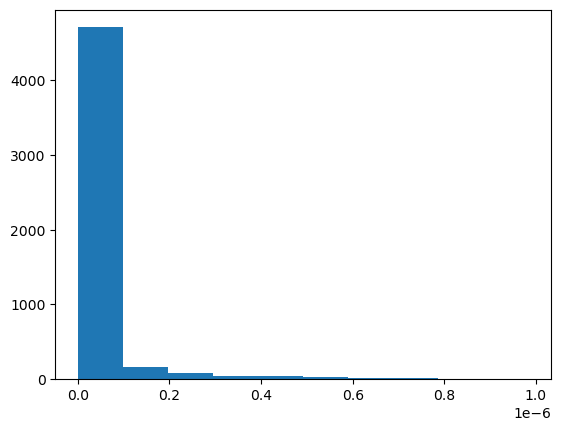

In [7]:
plt.hist(sol_opt.rms_residuals);

In [8]:
IF = simpson((sol_free.y.T[:, 1] + sol_free.y.T[:, 4])**2, x=sol_free.t)
IO = simpson((sol_opt.y.T[:, 1] + sol_opt.y.T[:, 4])**2, x=sol_opt.x)

data = {}
data["Sol_opt"] = sol_opt
data["Sol_free"] = sol_free
data["Nj0"] = Nj0
data["Nc0"] = 1-Nj0
data["Betac"] = betac_val
data["Betaj"] = betaj_val
data["gamma"] = gamma_val
data["ucj0"] = Lcj0_val
data["ujc0"] = Ljc0_val
data["Ic0"] = X0[1]
data["Ij0"] = X0[4]
data["ai"] = ai_val
data["au"] = au_val
data["w"] = w_val
data["u_jc_t_n"] = L_jc_t_n
data["u_cj_t_n"] = L_cj_t_n
data["u_jc_t"] = L_jc_t
data["u_cj_t"] = L_cj_t
data["delta_I"] = IF-IO
with open('Solutions/Model{}.pkl'.format(model_name), 'wb') as f:
    pickle.dump(data, f)